## Dynamic nanoscale architecture of synaptic vesicle fusion in mouse hippocampal neurons
### Mesoscopic simulation of synaptic vesicle docking -- part 2: morphology

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utilities import stats
import glob
import pandas as pd

In [2]:
n_syt1_list = [0, 10, 20, 30]

Loading the 'combined data' from the pickle:

In [3]:
combined_data_file_path = "./trajectory/combined_data.pkl"

combined_df = None

if not glob.glob(combined_data_file_path):
    print("Processed data file not found! Please run the 'data_preprocessor' notebook first!")
else:
    combined_df = pd.read_pickle(combined_data_file_path)

Using the initial gap between vesicle and target to filter particles belonging to each:

In [4]:
subset = combined_df.query(f"n_syt1 == {0} and replica == {1}")

pos = subset['membrane_pos'].to_numpy()

vesicle_particles = pos[0][:, 2] > -25.0
target_particles = np.logical_not(vesicle_particles)

vesicle_particles_indices = np.arange(0, pos[0].shape[0])[vesicle_particles]

Plotting a cross-section of particle positions in a selection of simulation trajectory frames:

In [5]:
def plot_cross_section (ax, pos, color):

    sel = np.abs(pos[:, 1]) < 5
    x = pos[sel, 0]
    y = pos[sel, 2]

    ax.scatter(x, y, alpha=0.5, s=20, edgecolor='none', color=color)
    ax.axis('off')


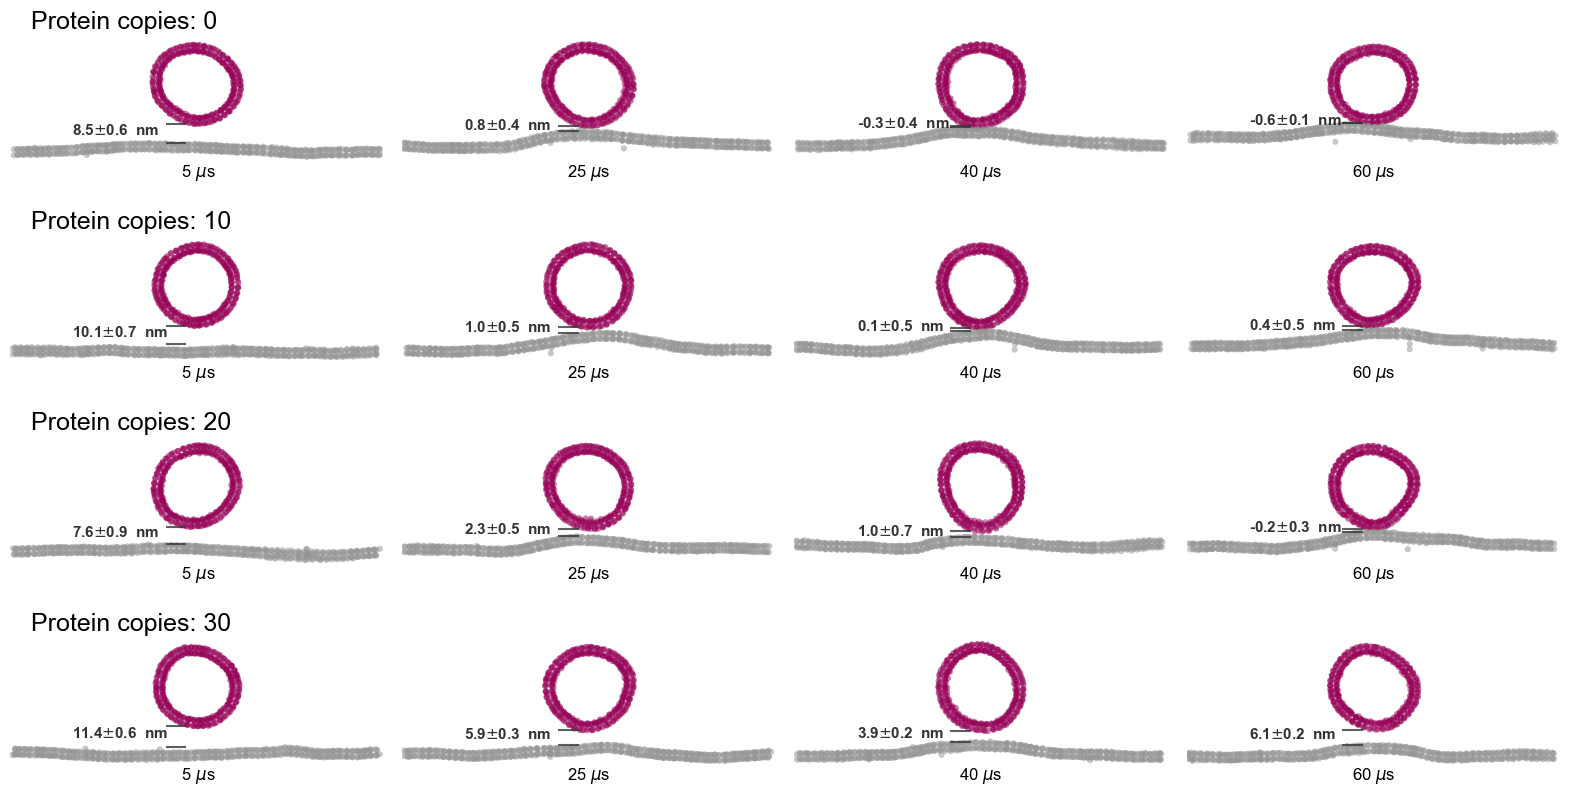

In [6]:
frame_list = [50, 250, 400, 600]

nrows = len(n_syt1_list)
ncols = len(frame_list)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 2.5 * nrows))
fig.subplots_adjust(wspace=0.05)

for n_syt1, _ax in zip(n_syt1_list, ax):

    _ax[0].text(-80, 30, f'Protein copies: {n_syt1}', ha='left', font={'family':'arial', 'size': 18})
    
    for frame_ind, __ax in zip(frame_list, _ax):
    
        vesicle_pos = []
        target_pos = []
        gap_sample = []

        subset = combined_df.query(f"n_syt1 == {n_syt1}")
        replica_list = np.unique(subset['replica'])
        
        for replica_ind in [1]:
            
            subset = combined_df.query(f"n_syt1 == {n_syt1} and replica == {replica_ind}")
            
            membrane_pos = subset['membrane_pos'].to_numpy()
            vesicle_target_gap = subset['vesicle_target_gap'].to_numpy()
            time = subset['time'].to_numpy()
            
            for _f in range(max(0, frame_ind - 5), min(membrane_pos.shape[0], frame_ind)):
                vesicle_pos.append(membrane_pos[_f][vesicle_particles, :].copy())
                target_pos.append(membrane_pos[_f][target_particles, :].copy())
                gap_sample.append(vesicle_target_gap[_f])
    
        vesicle_pos = np.mean(vesicle_pos, axis=0)
        vesicle_com = np.mean(vesicle_pos, axis=0)
        vesicle_pos = vesicle_pos - vesicle_com
    
        target_pos = np.mean(target_pos, axis=0)
        target_pos = target_pos - vesicle_com
    
        plot_cross_section(__ax, vesicle_pos, 'xkcd:dark magenta')
        plot_cross_section(__ax, target_pos, 'xkcd:gray')
    
        __ax.text(0, -50, fr"{time[frame_ind]:2.0f} $\mu$s", ha='center', font={'family':'arial', 'size': 12})
    
        y1 = np.amax(target_pos[np.abs(target_pos[:, 0]) < 10.0, 2])
        y2 = np.amin(vesicle_pos[:, 2])
        
        xmin, xmax = -15.0, -5.0
        __ax.hlines(y=[y1, y2], xmin=xmin, xmax=xmax, colors='xkcd:dark gray', alpha=0.8)
        
        # Add text beside the arrow
        gap_text = fr'{np.mean(gap_sample):2.1f}$\pm${np.std(gap_sample):2.1f}  nm'
        __ax.text(xmin - 45.0, (y1 + y2) / 2 + 1.5, gap_text, va='center', alpha=0.8,
                 font={'family':'arial', 'weight':'bold', 'size':11})
    
        __ax.set_ylim(-50, 40)
        __ax.set_xlim(-90, 90)
        